<h1 align="center">Facial Recognition: The Eigenfaces Method </h1>

    Ethan Crawford
    11/15/22


<h3> Objective: </h3> Facial recognition algorithms attempt to match a person’s portrait to a database of many portraits. Facial recognition is becoming increasingly important in security, law enforcement, artificial intelligence, and other areas. Though humans can easily match pictures to people, computers are beginning to surpass humans at facial recognition. In this lab, I implement a basic facial recognition system that relies on eigenvectors and the SVD to efficiently determine the difference between faces.


In [2]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.linalg as la
from imageio.v2 import imread

<h3>Preparing an Image Database</h3> The <strong>faces94</strong> face image dataset<sup>1</sup>
contains several photographs of 153 people, organized into folders
by person. To perform facial recognition on this dataset, select one image per person and convert
these images into a database. For this particular facial recognition algorithm, the entire database
can be stored in just a few NumPy arrays.

Digital images are stored on computers as arrays of pixels. Therefore, an $m × n$ image can be
stored in memory as an $m × n$ matrix or, equivalently, as an $mn$-vector by concatenating the rows of the matrix. Then a collection of $k$ images can be stored as a single $mn × k$ matrix $F$, where each
column of $F$ represents a single image.

<sup><sup><sup> 1 </sup></sup></sup> <sup><sup> See http://cswww.essex.ac.uk/mv/allfaces/faces94.html. </sup></sup>

The following function obtains one image for each person in the <strong>faces94</strong> dataset and converts
the collection of images into an $mn × k$ matrix $F$ described above.

In [3]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

The following function obtains accepts an image as a flattened $mn$-vector, along with its original dimensions $m$ and $n$, converts it into its original shape, and displays the result.

In [4]:
def show(rand_int, image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        rand_int (int): A random integer from 0 to 153
        image ((mn,) ndarray): The flattened image from the dataset corresponding to rand_int
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    # Reshape the flattened image into a matrix
    original_image = np.reshape(image,(m,n))
    # Display the image
    plt.imshow(original_image, cmap="gray")
    plt.axis("off")
    plt.title(f"Image #{rand_int}", size=16)
    plt.show()

    1. Use get_faces() and show() to display a random image from the dataset

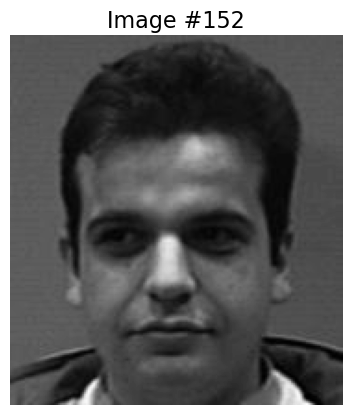

In [5]:
# Display a random image from the dataset
img = get_faces()
rand_int = random.randint(0,152)
show(rand_int, img.T[rand_int])

In [6]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    # Problems 2-3
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        # Get all images
        self.F = get_faces(path)
        self.mu = np.sum(self.F, axis=1)/len(self.F[0])
        self.Fbar = (self.F.T - self.mu).T
        self.U = la.svd(self.Fbar, full_matrices=False)[0]


    # Problem 3
    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        return self.U.T[:s] @ A

    # Problem 5
    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        g_hat = self.U.T[:s] @ (g - self.mu)
        f_hat = self.project(self.Fbar,s)
        j = np.argmin(la.norm(f_hat.T - g_hat, ord=2, axis=1))
        return j

    # Problem 6
    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """

        # Locate the closest match from the dataset
        closest = self.find_nearest(image,s)

        # Reshape the flattened images into a matrix
        matched_image = np.reshape(self.F[:,closest], (m,n))
        
        return matched_image

<hr><h3>The Eigenfaces Method</h3> 

With the image database $F$, we could construct a simple facial recognition system with the following
strategy: 

- Let $g$ be an $mn$-vector representing an unknown face that is not part of the database $F$.
Then, the $f_i$ that minimizes $||g−f_i||_2 $ is the matching face. 

Unfortunately, computing $||g−f_i||_2 $ for each
$i$ is very computationally expensive, especially if the images are high-resolution and/or the database
contains a large number of images. The eigenfaces method is a way to reduce the computational cost
of finding the closest matching face by focusing on only the most important features of each face.
Because the method ignores less significant facial features, it is also usually more accurate than the
naïve method.

The first step of the algorithm is to shift the images by the mean face. Shifting a set of data by the mean exaggerates the distinguishing features of each entry, skewing an unknown image to look more like images in the dataset.





 

In [21]:
def reshape(image, m=200, n=180):
    '''Reshape an image'''
    return np.reshape(image,(m,n))

def plot_face(image, position, title, columns=6, text=None, text_loc=None):
    plt.subplot(1,columns, position)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title(title)
    if text is not None:
        plt.gcf().text(text_loc, .72, text, fontsize=8)

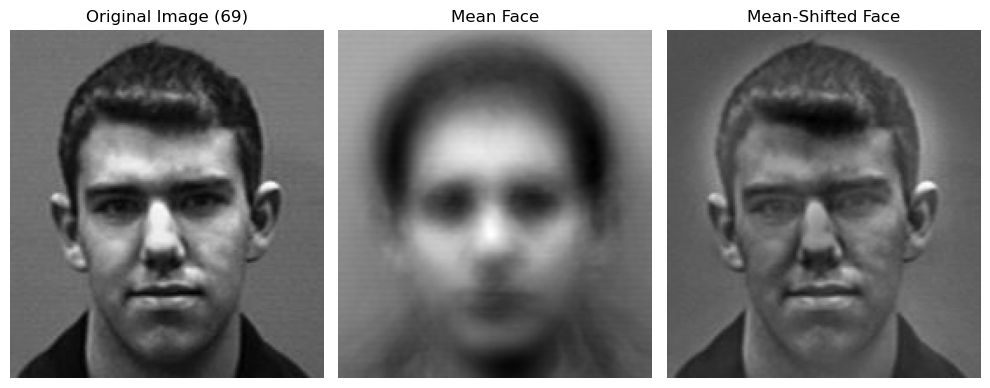

In [22]:
img = get_faces()
rand_int = random.randint(0,152)
m, n = 200, 180
obj = FacialRec()

# Plot the original image, the mean face, and the mean-shifted face
plt.figure(figsize=(10,5))

plot_face(reshape(obj.mu), 2, "Mean Face", 3)
plot_face(reshape(obj.F.T[rand_int]), 1, f"Original Image ({rand_int})", 3)
plot_face(reshape(obj.Fbar.T[rand_int]), 3, "Mean-Shifted Face", 3)

plt.tight_layout()
plt.show()

The whole process from start to finish:

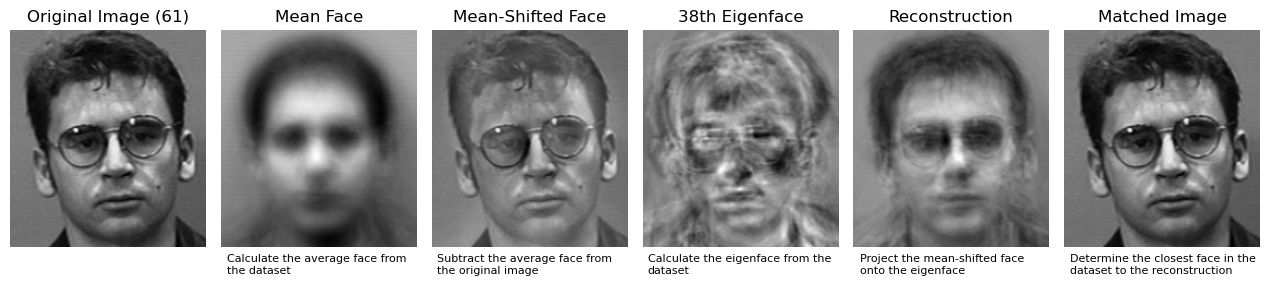

In [25]:
img = get_faces()
rand_int = random.randint(0,152)
m, n = 200, 180
obj = FacialRec()

# Plots
plot_face(reshape(obj.F.T[rand_int]), 1, f"Original Image ({rand_int})")
plot_face(reshape(obj.mu), 2, "Mean Face", text="Calculate the average face from\nthe dataset", text_loc=.363)
plot_face(reshape(obj.Fbar.T[rand_int]), 3, "Mean-Shifted Face", text="Subtract the average face from\nthe original image", text_loc=.69)

s=38
image1 = obj.Fbar.T[rand_int].T
s_proj1 = obj.project(image1, s)
reconstruct1 = (obj.U[:,:s] @ s_proj1) + obj.mu

plot_face(reshape(obj.U.T[38]), 4, "38th Eigenface", text="Calculate the eigenface from the\ndataset", text_loc=1.02)
plot_face(reshape(reconstruct1), 5, "Reconstruction", text='Project the mean-shifted face\nonto the eigenface', text_loc=1.351)
plot_face(reshape(obj.match(obj.F.T[rand_int])), 6, "Matched Image", text="Determine the closest face in the \ndataset to the reconstruction", text_loc=1.68)

plt.tight_layout(rect=(0, 0, 2, 2))
plt.show()
